# Food Vision Big

In [2]:
! nvidia-smi

Mon Mar 13 16:25:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     8W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [3]:
# use mixed precision training to speed up the GPU computation by 3x
# is beneficial when GPU compute capability is above 7.0

In [4]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-da0ffd6c-6838-fa69-79b0-d270f8ef789f)
GPU 1: Tesla T4 (UUID: GPU-57c15e19-69c4-7423-08b4-7c20198b0ce5)


In [5]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-13 16:25:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-13 16:25:58 (55.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [43]:
from helper_functions import (create_tensorboard_callback,
                              plot_loss_curves,
                              compare_historys)
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [7]:
# use tfds to get data
# gives data directly in the form of tensors

In [8]:
import tensorflow_datasets as tfds

In [9]:
datasets = tfds.list_builders()
len(datasets)

1138

In [10]:
print("food101" in datasets)

True


In [11]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True, 
                                             as_supervised=True, # data gets returned in tuple format (data, label),
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteWBES25/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteWBES25/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Become one with data
### class names
### shape of input
### datatype of input
### labels (one-hot encoded or label encoded)
### labels match with class names? 

In [12]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path=PosixGPath('/tmp/tmpffz_d2oxtfds'),
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_exam

In [13]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [14]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [15]:
# take one sample
train_data_sample = train_data.take(1)
train_data_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [16]:
# output information about our sample
for image, label in train_data_sample:
  print(f""" 
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]} 
  """)

 
  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 90
  Class name (str form): spaghetti_bolognese 
  


In [17]:
# we see from the label, that the labels are NOT one hot encoded

In [18]:
# min and max values of image tensor
tf.reduce_min(image).numpy(), tf.reduce_max(image).numpy()

(0, 255)

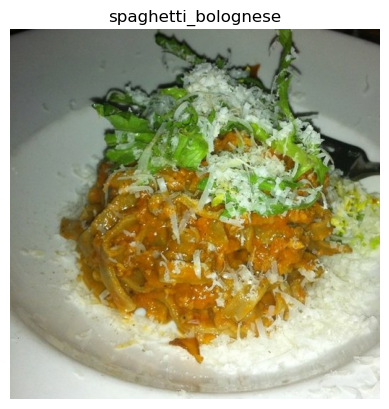

In [19]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis("off")
plt.show()

In [20]:
# preprocess the images
def preprocess_image(image, label, img_shape=224):
  # resize image
  image = tf.image.resize(image, [img_shape, img_shape])
  # scale image
  #image = image / 255. # not required for EfficientNetBX models
  # cast image to float32
  return tf.cast(image, dtype=tf.float32), label

In [21]:
# check preprocessed image
preprocessed_image = preprocess_image(image, label)[0]

In [22]:
print(image.shape, image.dtype)
print(preprocessed_image.shape, preprocessed_image.dtype)

(512, 512, 3) <dtype: 'uint8'>
(224, 224, 3) <dtype: 'float32'>


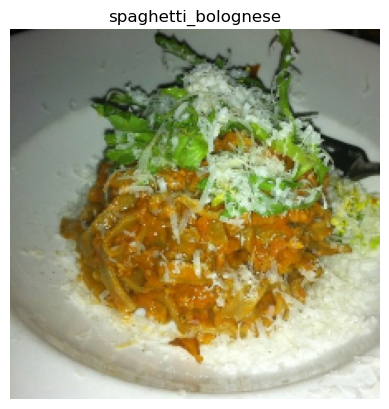

In [23]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib compatibility)
plt.imshow(preprocessed_image/255.)
plt.title(class_names[label])
plt.axis(False);

# Batch and prepare datasets

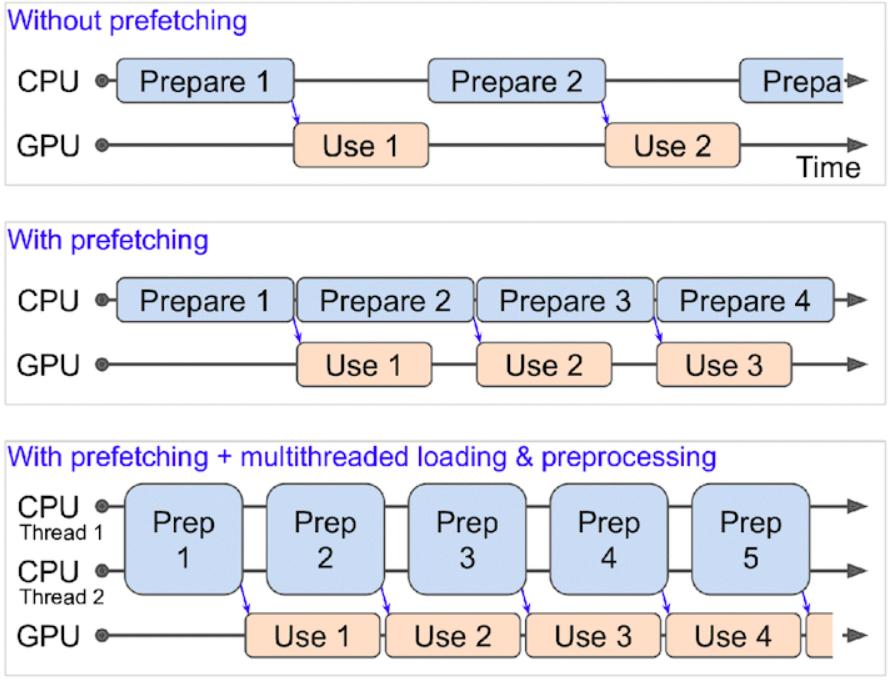

In [24]:
# map preprocessing function to training data (and parallelize)
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# map preprocessing function to testing data (and parallelize)
test_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [25]:
train_data, test_data 

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Create modelling callbacks

In [93]:
from helper_functions import create_tensorboard_callback

In [94]:
checkpoint_path = "model_checkpoints/cp.ckpt"
checkpointer = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                  monitor="val_accuracy",
                                                  save_best_only=True,
                                                  save_weights_only=True,
                                                  verbose=0)

# Setup Mixed Precision Training

In [26]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [27]:
mixed_precision.global_policy()

<Policy "mixed_float16">

# Build feature extraction model

In [29]:
from tensorflow.keras.layers.experimental import preprocessing

In [30]:
input_shape = (224,224,3)
base = tf.keras.applications.EfficientNetB0(include_top=False)
base.trainable = False

input = tf.keras.layers.Input(shape=input_shape, name="input_layer")
# EfficientNetBX has inbuilt rescaling
# x = preprocessing.Rescaling(1./255)(input)
x = base(input, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)   
output = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="output_layer")(x) # add dtype=tf.float32 in output layer for mixed-precision training    
model_0 = tf.keras.models.Model(input, output)

model_0.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",  
              metrics=["accuracy"])

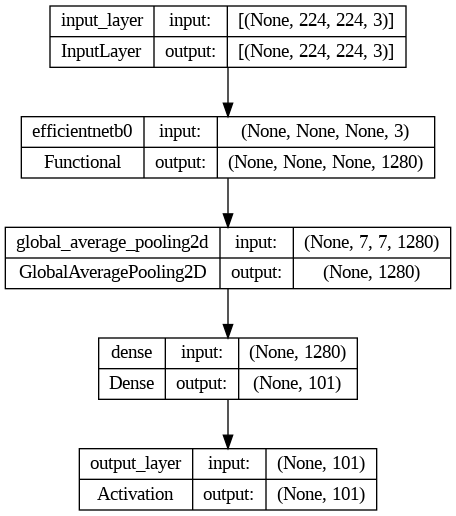

In [31]:
tf.keras.utils.plot_model(model_0, show_shapes=True)

In [32]:
for layer in model_0.layers:
  print(layer.dtype, layer.dtype_policy)

float32 <Policy "float32">

float32 <Policy "mixed_float16">

float32 <Policy "mixed_float16">

float32 <Policy "mixed_float16">

float32 <Policy "float32">


In [33]:
history_0 = model_0.fit(train_data,
                      epochs=5,
                      validation_data=test_data,
                      validation_steps=int(0.15*len(test_data)),
                      callbacks=[create_tensorboard_callback(dir_name="training_logs", experiment_name="model_0"), checkpointer])

Saving TensorBoard log files to: training_logs/model_0/20230313-150646

Epoch 1/5

2368/2368 [==============================] - 234s 86ms/step - loss: 1.7154 - accuracy: 0.5828 - val_loss: 1.1260 - val_accuracy: 0.6970

Epoch 2/5

2368/2368 [==============================] - 206s 86ms/step - loss: 1.2004 - accuracy: 0.6888 - val_loss: 1.0376 - val_accuracy: 0.7124

Epoch 3/5

2368/2368 [==============================] - 198s 82ms/step - loss: 1.0550 - accuracy: 0.7230 - val_loss: 0.9981 - val_accuracy: 0.7243

Epoch 4/5

2368/2368 [==============================] - 203s 85ms/step - loss: 0.9605 - accuracy: 0.7473 - val_loss: 0.9759 - val_accuracy: 0.7264

Epoch 5/5

2368/2368 [==============================] - 193s 81ms/step - loss: 0.8895 - accuracy: 0.7663 - val_loss: 0.9749 - val_accuracy: 0.7262


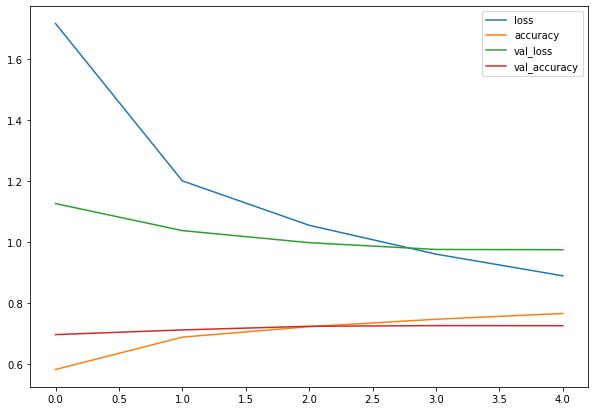

In [34]:
import pandas as pd
pd.DataFrame(history_0.history).plot(figsize=(10,7))
plt.show()

In [35]:
model_0.evaluate(test_data)

790/790 [==============================] - 60s 75ms/step - loss: 0.9780 - accuracy: 0.7324


[0.9779554605484009, 0.7323960661888123]

# Fine tuning 

In [28]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2023-03-13 16:38:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  25.6MB/s    in 0.6s    

2023-03-13 16:38:41 (25.6 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [29]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [31]:
model_1 = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [32]:
model_1.evaluate(test_data)

790/790 [==============================] - 63s 65ms/step - loss: 1.0881 - accuracy: 0.7065


[1.0881024599075317, 0.7065346240997314]

In [33]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [34]:
for layer in model_1.layers:
  layer.trainable = True

In [35]:
for layer in model_1.layers:
  print(layer.dtype_policy)

<Policy "float32">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "float32">


In [36]:
early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=3,
                                                 restore_best_weights=True)

In [37]:
checkpoint_path = "model_1_checkpoints/"
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  monitor="val_loss",
                                                  save_best_only=True,
                                                  save_weights_only=True)

In [38]:
# default learning_rate=0.001 we'll do 10x lower than this

In [39]:
model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["accuracy"])

In [40]:
history_1 = model_1.fit(train_data,
                        epochs=100,
                        validation_data=test_data,
                        validation_steps=int(0.15*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="model_1_tensorboard_logs", experiment_name="fine_tuning_model_1"),
                                   early_stopper,
                                   checkpointer])

Saving TensorBoard log files to: model_1_tensorboard_logs/fine_tuning_model_1/20230313-164610
Epoch 1/100
2368/2368 [==============================] - 435s 163ms/step - loss: 0.9230 - accuracy: 0.7510 - val_loss: 0.7823 - val_accuracy: 0.7815
Epoch 2/100
2368/2368 [==============================] - 383s 161ms/step - loss: 0.5796 - accuracy: 0.8382 - val_loss: 0.7844 - val_accuracy: 0.7889
Epoch 3/100
2368/2368 [==============================] - 388s 162ms/step - loss: 0.3327 - accuracy: 0.9059 - val_loss: 0.8501 - val_accuracy: 0.7916
Epoch 4/100
2368/2368 [==============================] - 384s 161ms/step - loss: 0.1734 - accuracy: 0.9493 - val_loss: 0.9823 - val_accuracy: 0.7858


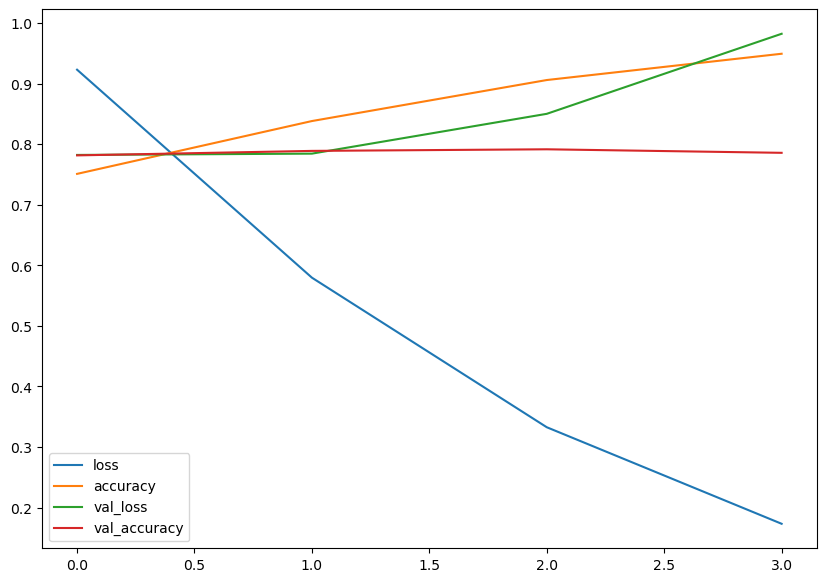

In [44]:
pd.DataFrame(history_1.history).plot(figsize=(10,7))
plt.show()

In [45]:
model_1.evaluate(test_data)

790/790 [==============================] - 52s 66ms/step - loss: 0.8004 - accuracy: 0.7787


[0.8004037141799927, 0.7786930799484253]

In [48]:
# ! tensorboard dev upload --logdir model_1_tensorboard_logs \
#     --name "Fine Tuning of Food101 dataset" \
#     --description "Fine tuning of Food101 dataset by using EfficientNetB0 architecture"